<a href="https://colab.research.google.com/github/jackkim-usd/AAI521-group4/blob/jack/AAI_521_Final_Project_Jack_Kim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow tensorflow-datasets scikit-learn

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [3]:
# Load full TFDS split once
(ds_all, ds_info) = tfds.load(
    "plant_village",
    split="train",
    as_supervised=True,
    with_info=True
)

total = ds_info.splits["train"].num_examples
print("Total images:", total)

# Shutffle but same seed for everyone (seed=4 because we're group 4)
ds_all = ds_all.shuffle(10000, seed=4, reshuffle_each_iteration=False)

# Fixed subset sizes because our dataset is too large, causing our code to crash even on GPU
train_count = 4000
val_count   = 800
test_count  = 800

train_ds = ds_all.take(train_count)
rest_ds  = ds_all.skip(train_count)
val_ds   = rest_ds.take(val_count)
test_ds  = rest_ds.skip(val_count).take(test_count)

train_count, val_count, test_count

Total images: 54303


(4000, 800, 800)

In [4]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, img_size, batch_size, training):
    def _resize_normalize(image, label):
        image = tf.image.resize(image, (img_size, img_size))
        image = tf.cast(image, tf.float32)
        return image, label

    ds = ds.map(_resize_normalize, num_parallel_calls=AUTOTUNE)

    if training:
        ds = ds.shuffle(1000)
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

In [6]:
num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

In [7]:
def build_efficientnet(model_name, img_size, num_classes):
    if model_name == "b0":
        base = tf.keras.applications.EfficientNetB0(
            include_top=False,
            weights="imagenet",
            input_shape=(img_size, img_size, 3),
        )
    elif model_name == "b3":
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            weights="imagenet",
            input_shape=(img_size, img_size, 3),
        )
    elif model_name == "b4":
        base = tf.keras.applications.EfficientNetB4(
            include_top=False,
            weights="imagenet",
            input_shape=(img_size, img_size, 3),
        )
    else:
        raise ValueError("model_name must be 'b0', 'b3', or 'b4'.")

    base.trainable = False

    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name=f"EfficientNet_{model_name}")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [8]:
def plot_history(history, title=""):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title(f"{title} accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(f"{title} loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def run_experiment(model_name, img_size, batch_size=32, epochs=8):
    print(f"\n=== EfficientNet{model_name.upper()} @ {img_size}x{img_size} ===")

    train_prep = prepare_dataset(train_ds, img_size, batch_size, training=True)
    val_prep   = prepare_dataset(val_ds,   img_size, batch_size, training=False)
    test_prep  = prepare_dataset(test_ds,  img_size, batch_size, training=False)

    model = build_efficientnet(model_name, img_size, num_classes)

    history = model.fit(
        train_prep,
        validation_data=val_prep,
        epochs=epochs,
    )

    plot_history(history, title=f"EfficientNet{model_name.upper()}")

    y_true = []
    y_pred = []

    for batch_images, batch_labels in test_prep:
        logits = model.predict(batch_images, verbose=0)
        preds = np.argmax(logits, axis=1)
        y_true.extend(batch_labels.numpy())
        y_pred.extend(preds)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")

    print(f"Test accuracy: {acc:.4f}")
    print(f"Macro F1 score: {f1:.4f}\n")

    print("Classification report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        fmt="d",
        annot=False,
    )
    plt.title(f"Confusion matrix – EfficientNet{model_name.upper()}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return model, history, acc, f1


=== EfficientNetB0 @ 224x224 ===
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 426ms/step - accuracy: 0.0965 - loss: 3.5041 - val_accuracy: 0.2800 - val_loss: 2.9078
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 112s 374ms/step - accuracy: 0.2944 - loss: 2.8519 - val_accuracy: 0.4238 - val_loss: 2.4586
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 379ms/step - accuracy: 0.4153 - loss: 2.4425 - val_accuracy: 0.5400 - val_loss: 2.1315
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 374ms/step - accuracy: 0.5037 - loss: 2.1385 - val_accuracy: 0.6075 - val_loss: 1.8759
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 382ms/step - accuracy: 0.5755 - loss: 1.9229 - val_accuracy: 0.6550 - val_loss: 1.6754


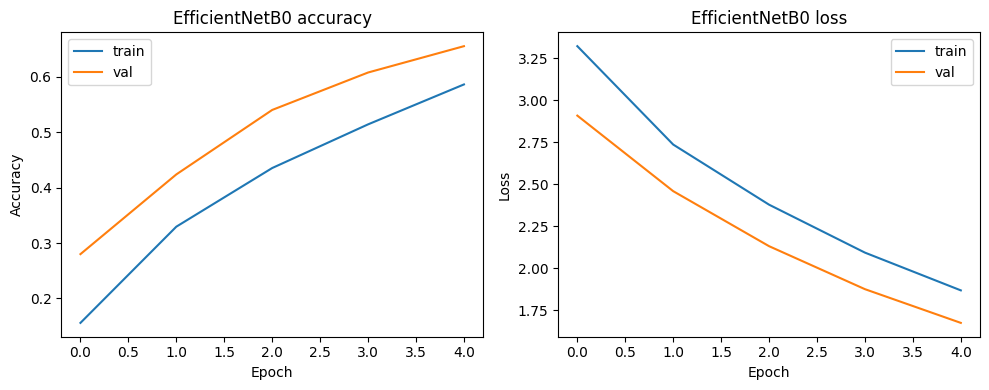

Test accuracy: 0.6488
Macro F1 score: 0.4571

Classification report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.00      0.00      0.00        10
                            Apple___Black_rot       1.00      0.50      0.67        12
                     Apple___Cedar_apple_rust       0.00      0.00      0.00         3
                              Apple___healthy       0.61      0.65      0.63        17
                          Blueberry___healthy       0.72      1.00      0.84        18
                             Cherry___healthy       1.00      0.33      0.50        12
                      Cherry___Powdery_mildew       0.00      0.00      0.00        20
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00        10
                           Corn___Common_rust       0.89      0.94      0.91        17
                               Corn___healthy       1.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


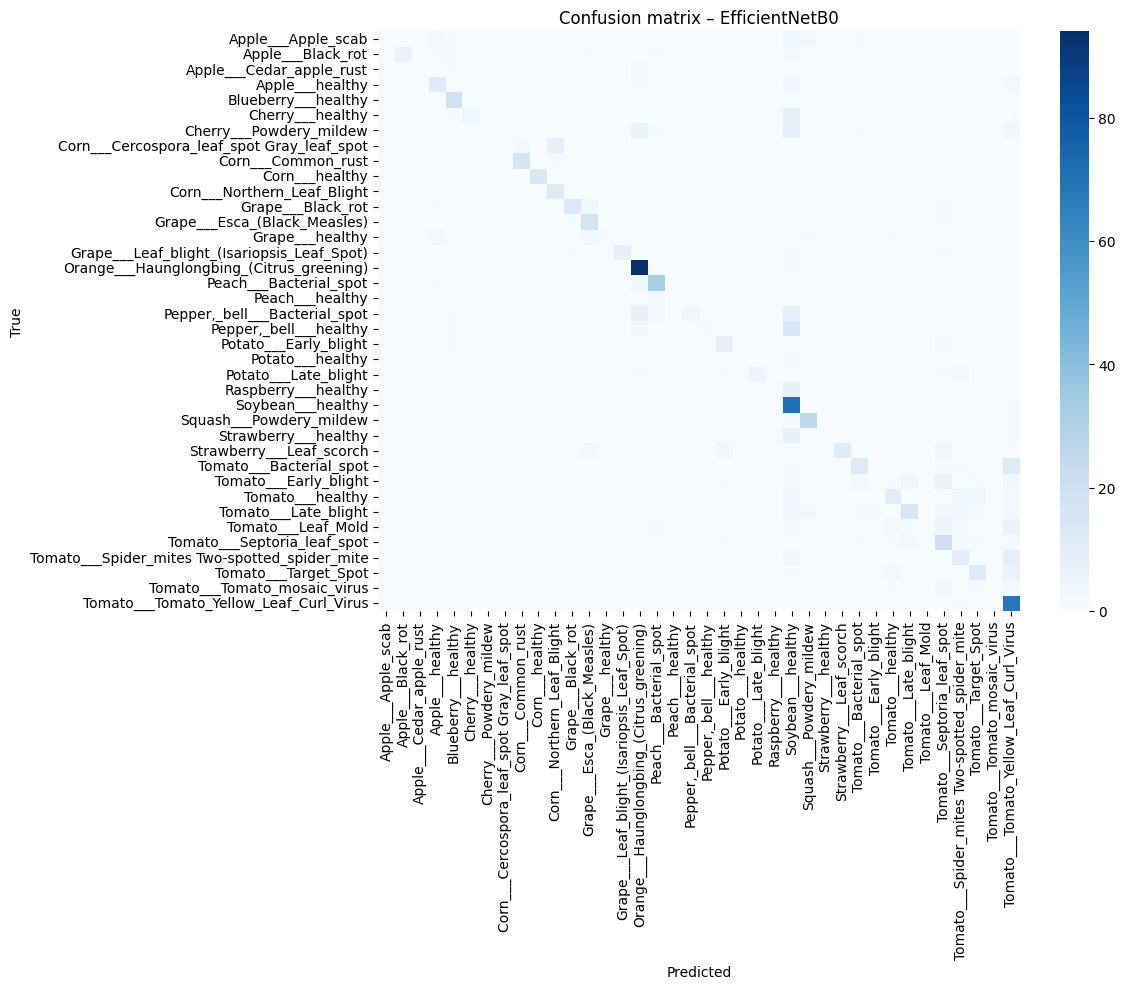

In [11]:
# EfficientNetB0
model_b0, hist_b0, acc_b0, f1_b0 = run_experiment(
    model_name="b0",
    img_size=224,
    batch_size=32,
    epochs=5,
)

In [12]:
print("EfficientNetB0 results:")
print(f"Accuracy: {acc_b0:.4f}")
print(f"Macro F1: {f1_b0:.4f}")

EfficientNetB0 results:
Accuracy: 0.6488
Macro F1: 0.4571


In [ ]:
# EfficientNetB3
model_b3, hist_b3, acc_b3, f1_b3 = run_experiment(
    model_name="b3",
    img_size=300,
    batch_size=16,
    epochs=5,
)


=== EfficientNetB3 @ 300x300 ===
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 163s 440ms/step - accuracy: 0.1083 - loss: 3.4213 - val_accuracy: 0.3600 - val_loss: 2.6566
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 409ms/step - accuracy: 0.3671 - loss: 2.5742 - val_accuracy: 0.5350 - val_loss: 2.1145
Epoch 3/5


In [ ]:
print("EfficientNetB3 results:")
print(f"Accuracy: {acc_b3:.4f}")
print(f"Macro F1: {f1_b3:.4f}")

In [ ]:
# EfficientNetB4
model_b4, hist_b4, acc_b4, f1_b4 = run_experiment(
    model_name="b4",
    img_size=300, #ideally 380 but reduced to save it from crashing
    batch_size=8,
    epochs=5,
)

In [ ]:
print("EfficientNetB4 results:")
print(f"Accuracy: {acc_b4:.4f}")
print(f"Macro F1: {f1_b4:.4f}")

In [ ]:
https://github.com/jackkim-usd/AAI521-group4.git